# Initalize libraries

## Import libraries

In [1]:
import sys, os
import time
from os.path import join
from os import path
from importlib import reload
from getpass import getuser

import xarray as xr
import h5py
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Open nexus files
from nexusformat.nexus import *

# pyFAI
import pyFAI
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.detectors import Detector

# Self-written libraries
sys.path.append(join(os.getcwd(), "library"))
import support_functions as sup
import interactive
from interactive import cimshow

# Gifs
import imageio

plt.rcParams["figure.constrained_layout.use"] = True  # replaces plt.tight_layout

In [2]:
# Is there a GPU?
try:
    # Cupy
    import cupy as cp
    import cupyx as cpx

    GPU = True

    print("GPU available")

    # Self-written library
    import CCI_core_cupy as cci
except:
    GPU = False
    import CCI_core as cci

    print("GPU unavailable")

GPU available


In [3]:
# interactive plotting
import ipywidgets

%matplotlib widget

# Auto formatting of cells
%load_ext jupyter_black

## Experiment specific Functions

In [148]:
PROPOSAL = 11019143
USER = getuser()

### Loading

In [149]:
BASEFOLDER = "/asap3/petra3/gpfs/p04/2023/data/%s/" % PROPOSAL
subfolder = "FGT"
sample_name = "2310_FGT"


# Load image files
def load_images(im_id):
    fname = join(BASEFOLDER, "raw", subfolder, "%s_%05d.nxs" % (sample_name, im_id))

    with nxload(fname) as f:
        im_out = np.array(f["scan"]["data"]["ccd"][()])
        print("Loaded: %s (%d frames)" % (fname, im_out.shape[0]))
    return im_out.squeeze()


# Load any kind of data from collection
def load_collection(scan_id, field):
    fname = join(BASEFOLDER, "raw", subfolder, "%s_%05d.nxs" % (sample_name, scan_id))

    with nxload(fname) as f:
        data = np.array(f["scan"]["instrument"]["collection"][field][()])
        print("Loaded: %s" % (fname))
    return np.squeeze(data)


# Load mono energy
def load_energy(scan_id):
    fname = join(BASEFOLDER, "raw", subfolder, "%s_%05d.nxs" % (sample_name, scan_id))

    with nxload(fname) as f:
        data = np.array(f["scan"]["instrument"]["mono"]["energy"][()])
        print("Loaded: %s" % (fname))
    return np.squeeze(data)


# Load any kind of data from measurements
def load_data(scan_id, field):
    fname = join(BASEFOLDER, "raw", subfolder, "%s_%05d.nxs" % (sample_name, scan_id))

    with nxload(fname) as f:
        data = np.array(f["scan"]["data"][field][()])
        print("Loaded key %s of %s" % (field, fname))
    return np.squeeze(data)


# Full image loading procedure
def load_processing(im_id):
    # Load data
    images = load_images(im_id)

    # Average over images
    if images.ndim > 1:
        image = np.mean(images, axis=0)
    else:
        image = images.copy()

    return image, images

### Masking

In [150]:
from matplotlib.widgets import PolygonSelector
from matplotlib.path import Path


def create_single_polygon_mask(shape, coordinates):
    """
    Creates a polygon mask from coordinates of corner points

    Parameter
    =========
    shape : int tuple
        shape/dimension of output array
    coordinates: nested list
        coordinates of polygon corner points [[yc_1,xc_1],[yc_2,xc_2],...]


    Output
    ======
    mask: array
        binary mask where filled polygon is "1"
    ======
    author: ck 2023
    """

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    x, y = x.flatten(), y.flatten()

    points = np.vstack((x, y)).T

    path = Path(coordinates)
    mask = path.contains_points(points)
    mask = mask.reshape(shape)
    return mask


def create_polygon_mask(shape, coordinates):
    """
    Creates multiple polygon masks from set of coordinates of corner points

    Parameter
    =========
    shape : int tuple
        shape/dimension of output array
    coordinates: nested list
        coordinates of polygon corner points for multiple polygons
        [[[yc_1,xc_1],[yc_2,xc_2],...],[[yc_1,xc_1],[yc_2,xc_2],...]]

    Output
    ======
    mask: array
        binary mask where filled polygons are "1"
    ======
    author: ck 2023
    """

    if len(coordinates) == 1:
        mask = create_single_polygon_mask(shape, coordinates[0])

    # Loop over coordinates
    elif len(coordinates) > 1:
        mask = np.zeros(shape)
        for coord in coordinates:
            mask = mask + create_single_polygon_mask(shape, coord)
            mask[mask > 1] = 1

    return mask


def load_poly_masks(polygon_name_list, shape):
    """
    Loads set of polygon masks based on stored coordinates

    Parameter
    =========
    polygon_name_list : list
        keys of different mask coordinates to load

    Output
    ======
    mask: array
        binary mask where filled polygons are "1"
    ======
    author: ck 2023
    """

    mask = []

    # Load dictionary of coordinates
    mask_coordinates = load_poly_coordinates()

    # Loop over relevant mask keys
    for polygon_name in polygon_name_list:
        coord = mask_coordinates[polygon_name]
        mask.append(create_polygon_mask(shape, coord).astype(float))

    # Combine all individual mask layers
    mask = np.array(mask)
    mask = np.sum(mask, axis=0)
    mask[mask > 1] = 1

    return mask

# Experimental Details

In [151]:
# Dict with most basic experimental parameter
experimental_setup = {
    "ccd_dist": 0.395,  # ccd to sample distance
    "px_size": 15e-6,  # pixel_size of camera
    "binning": 1,  # Camera binning
}

# Setup for azimuthal integrator
detector = Detector(
    experimental_setup["binning"] * experimental_setup["px_size"],
    experimental_setup["binning"] * experimental_setup["px_size"],
)

# General saving folder
folder_general = sup.create_folder(join(BASEFOLDER, "processed"))
print("Output Folder: %s" % folder_general)

Output Folder: /asap3/petra3/gpfs/p04/2023/data/11019143/processed


# Load images


Loaded: /asap3/petra3/gpfs/p04/2023/data/11019143/raw/FGT/2310_FGT_01378.nxs


  0%|          | 0/1 [00:00<?, ?it/s]

Loaded: /asap3/petra3/gpfs/p04/2023/data/11019143/raw/FGT/2310_FGT_01378.nxs (17 frames)
Loaded key br1_master of /asap3/petra3/gpfs/p04/2023/data/11019143/raw/FGT/2310_FGT_01378.nxs


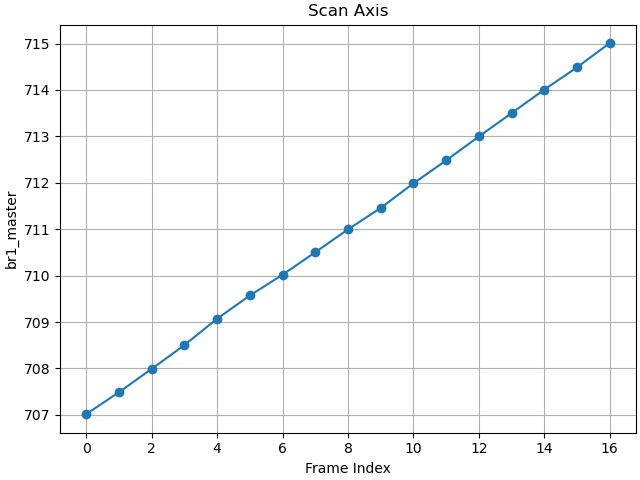

In [153]:
# Specify image ids
im_ids = np.arange(966, 1045 + 1)
im_ids = [1378]

# Which data from nexus files to load? (e.g. "br1_master", "energy","m_magnett_read", ...)
key = "br1_master"

# One image per scan id?
one_img = False

# Add experimental details
experimental_setup["energy"] = load_energy(im_ids[0])
experimental_setup["lambda"] = cci.photon_energy_wavelength(
    experimental_setup["energy"], input_unit="eV"
)

# Load data
images = []
scan_axis = []

for im_id in tqdm(im_ids):
    # load images
    if one_img is True:
        timages, _ = load_processing(im_id)
    elif one_img is False:
        _, timages = load_processing(im_id)

    # Append to data variable
    images.append(timages)

    # Load scan axis
    if key == "energy":
        scan_axis.append(np.round(load_energy(im_id), 2))
    else:
        scan_axis.append(load_data(im_id, key))

# Squeeze list
images = np.squeeze(images)
scan_axis = np.squeeze(scan_axis)

# Plot scan axis
fig, ax = plt.subplots()
ax.plot(scan_axis, "o-")
ax.set_title("Scan Axis")
ax.set_ylabel(key)
ax.set_xlabel("Frame Index")
ax.grid()

interactive(children=(FloatRangeSlider(value=(603.9000244140625, 658.7999877929688), description='contrast', l…

interactive(children=(IntSlider(value=0, description='nr', max=16), Output()), _dom_classes=('widget-interact'…

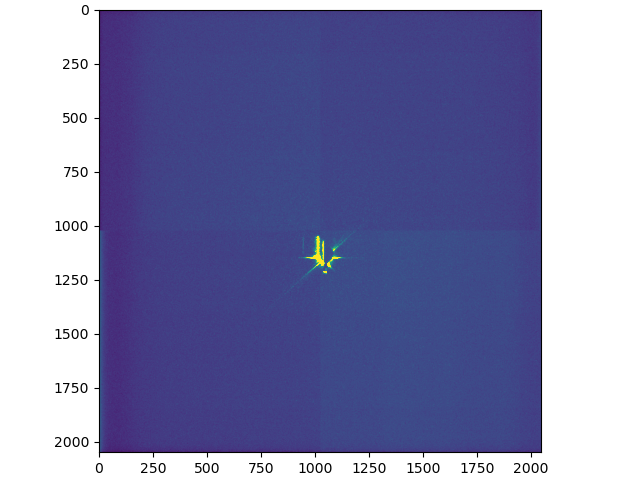

In [154]:
# Assign to xarray
# Setup xarray for images
data = xr.Dataset()
data[key] = xr.DataArray(scan_axis, dims=["index"])
data["images"] = xr.DataArray(images, dims=["index", "y", "x"])
data["image"] = data["images"].mean("index")
image = data["image"].values

# Assign im_id as attribute
data = data.assign_attrs({"im_id": im_id})

# Slideshow viewer
fig, ax = cimshow(data["images"])

# Draw beamstop mask

interactive(children=(FloatRangeSlider(value=(607.8941219554227, 618.288236730239), description='contrast', la…

Click on the figure to create a polygon corner.
Click `Add mask` to store coordinates and apply mask.
Press the 'esc' key to reset the polygon for new drawing.

Try holding the 'shift' key to move all of the vertices.
Try holding the 'ctrl' key to move a single vertex.
Button `Delete mask` deletes the masks recursively.


Button(button_style='warning', description='Add mask', layout=Layout(height='auto', width='100px'), style=Butt…

Button(description='Delete mask', layout=Layout(height='auto', width='100px'), style=ButtonStyle())

Output()

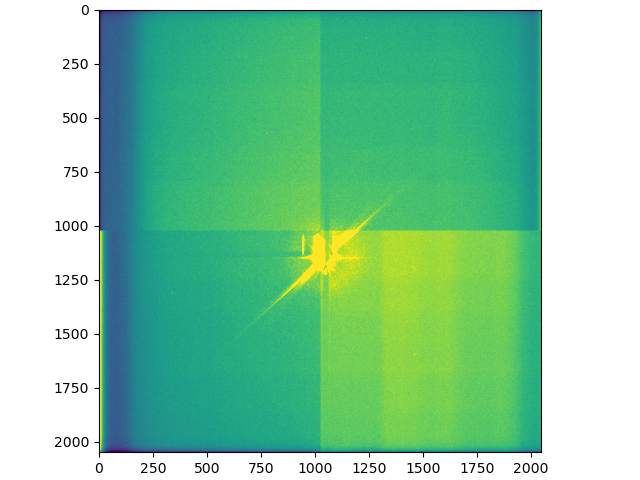

In [155]:
poly_mask = interactive.draw_polygon_mask(image)

Copy these coordinates into the 'load_poly_coordinates()' function:
[]


Text(0.5, 1.0, '1 - mask_draw')

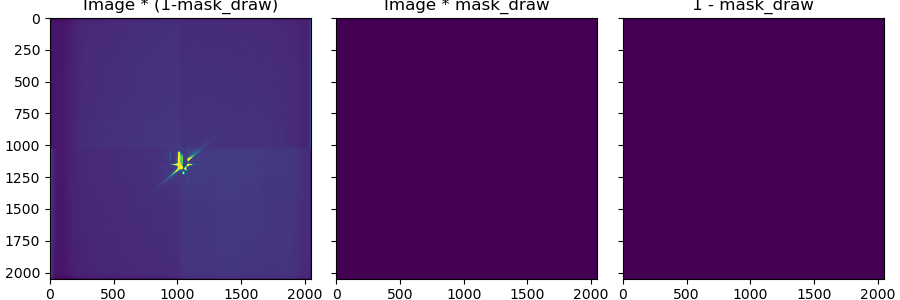

In [156]:
# Take poly coordinates and mask from widget
p_coord = poly_mask.coordinates
mask_draw = poly_mask.full_mask.astype(int)

print("Copy these coordinates into the 'load_poly_coordinates()' function:")
print(p_coord)

# Plot image with beamstop and valid pixel mask
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 3))
tmp = image * (1 - mask_draw)
mi, ma = np.percentile(tmp[tmp != 0], [0.1, 99.9])
ax[0].imshow(image * (1 - mask_draw), cmap="viridis", vmin=mi, vmax=ma)
ax[0].set_title("Image * (1-mask_draw)")

mi, ma = np.percentile(image * mask_draw, [0.1, 99.9])
ax[1].imshow(image * mask_draw, vmin=mi, vmax=ma)
ax[1].set_title("Image * mask_draw")

ax[2].imshow(1 - mask_draw)
ax[2].set_title("1 - mask_draw")

In [157]:
def load_poly_coordinates():
    """
    Dictionary that stores polygon corner coordinates of all drawn masks
    """

    # Setup dictonary
    mask_coordinates = dict()

    # Mask #1
    mask_coordinates["streaks"] = [
        [
            (622.5194062012534, 1496.382483308274),
            (987.9010641234265, 1173.9221647203321),
            (976.8955924992647, 1155.2128629592569),
            (924.069328703288, 1154.112315796841),
            (929.5720645153688, 1138.7046555230143),
            (968.0912151999353, 1140.9057498478464),
            (987.9010641234265, 1125.49808957402),
            (961.2433707892848, 1082.0876122071193),
            (984.3548612000246, 1086.4898008567839),
            (984.3548612000246, 1040.2668200353041),
            (1017.3712760725102, 1030.3618955735585),
            (1028.376747696672, 1050.17174449705),
            (1064.6948040564062, 1091.992536668865),
            (1072.3986341933194, 1085.3892536943677),
            (1072.3986341933194, 1027.0602540863101),
            (1094.409577441643, 1032.562989898391),
            (1096.6106717664754, 1069.9815934205412),
            (1219.871953957088, 929.1115566312697),
            (1251.7878216671575, 946.7203112299285),
            (1398.2828816921317, 810.2524604664127),
            (1416.992183453207, 828.9617622274878),
            (1101.135147839762, 1119.5062131053605),
            (1119.8444496008372, 1140.416609191268),
            (1289.3287126129294, 1142.6177035161004),
            (1289.3287126129294, 1152.522627977846),
            (1118.743902438421, 1159.125910952343),
            (1096.7329591900973, 1172.3324769013373),
            (1096.7329591900973, 1220.7565520476494),
            (1071.420374454525, 1228.4603821845626),
            (1034.0017709323747, 1232.8625708342274),
            (1011.990827684051, 1206.449438936239),
            (870.6316508212919, 1362.6048614037147),
            (653.8238598253035, 1517.7820113043967),
        ],
        [
            (933.1182750189521, 1038.1880099270936),
            (935.3193693437845, 1143.8405375190473),
            (954.0286711048595, 1143.8405375190473),
            (954.0286711048595, 1031.5847269525966),
        ],
    ]

    # Mask #2
    mask_coordinates["beamstop_left"] = [
        [
            (920.574059312001, 1108.7192485209798),
            (730.3901970926418, 1108.7192485209798),
            (738.0743935459491, 1149.0612799008438),
            (920.574059312001, 1150.9823290141708),
        ]
    ]

    return mask_coordinates

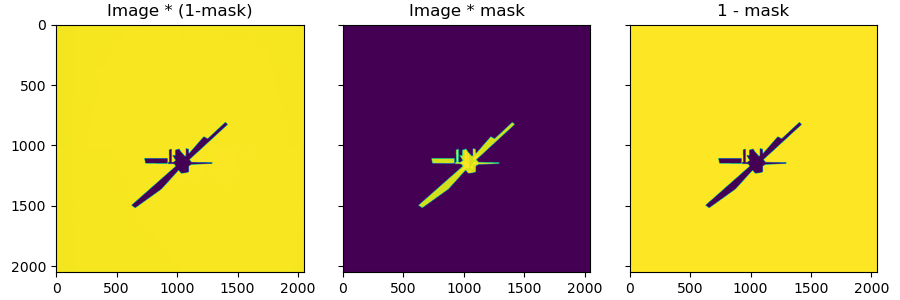

In [158]:
# Which drawn masks do you want to load? Use can combine multiple masks, e.g., ["bs_left_part", "bs_bot_part", "bs_top_part"]
polygon_names = ["streaks", "beamstop_left"]
mask = load_poly_masks(polygon_names, image.shape)

# Add to xarray
data["mask"] = xr.DataArray(mask, dims=["y", "x"])

# Plot image with beamstop and valid pixel mask
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 3))
mi, ma = np.percentile(image * (1 - mask), [0.1, 99.9])
ax[0].imshow(image * (1 - mask), cmap="viridis", vmin=mi, vmax=ma)
ax[0].set_title("Image * (1-mask)")

mi, ma = np.percentile(image * mask, [0.1, 99.9])
ax[1].imshow(image * mask, vmin=mi, vmax=ma)
ax[1].set_title("Image * mask")

ax[2].imshow(1 - mask)
ax[2].set_title("1 - mask")
plt.tight_layout()

## Basic widget to find center

Try to **align** the circles to the **center of the scattering pattern**. Care! Position of beamstop might be misleading and not represent the actual center of the hologram. 

interactive(children=(FloatRangeSlider(value=(603.9000244140625, 658.7999877929688), description='contrast', l…

interactive(children=(IntSlider(value=0, description='nr', max=16), Output()), _dom_classes=('widget-interact'…

interactive(children=(IntText(value=1145, description='c0', step=0), IntText(value=1045, description='c1', ste…

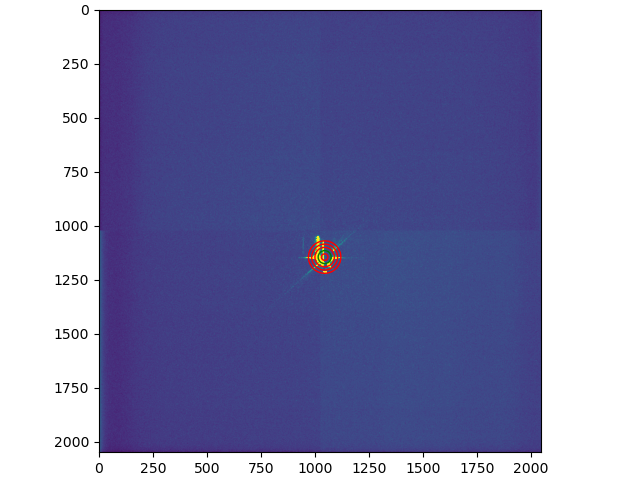

In [159]:
# Set center position via widget
c0, c1 = [1145, 1045]  # initial values
ic = interactive.InteractiveCenter(data["images"], c0=c0, c1=c1)

In [160]:
# Get center positions
center = [ic.c0, ic.c1]
print(f"Center:", center)

Center: [1145, 1045]


## Azimuthal integrator widget for finetuning
If scattering pattern is radial symmetric, move center position until scattering ring is a line after transformation in polar coordinates

In [161]:
# Setup azimuthal integrator for virtual geometry
ai = AzimuthalIntegrator(
    dist=experimental_setup["ccd_dist"],
    detector=detector,
    wavelength=experimental_setup["lambda"],
    poni1=center[0]
    * experimental_setup["px_size"]
    * experimental_setup["binning"],  # y (vertical)
    poni2=center[1]
    * experimental_setup["px_size"]
    * experimental_setup["binning"],  # x (horizontal)
)

Text(0.5, 1.0, 'Azimuthal integration')

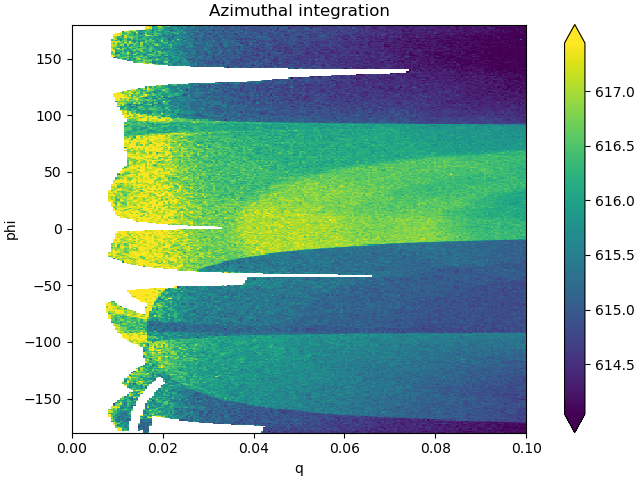

In [162]:
# Calc azimuthal integration
I_t, q_t, phi_t = ai.integrate2d(
    image,
    200,
    radial_range=(0, 0.1),
    unit="q_nm^-1",
    correctSolidAngle=False,
    dummy=np.nan,
    mask=mask,
)
az2d = xr.DataArray(I_t, dims=("phi", "q"), coords={"q": q_t, "phi": phi_t})

# Plot
fig, ax = plt.subplots()
mi, ma = np.nanpercentile(I_t, [1, 98])
az2d.plot.imshow(ax=ax, vmin=mi, vmax=ma)
plt.title(f"Azimuthal integration")

Left: 1d azimuthal Integration I(q)
Right: 2d azimuthal Integration I(q,chi)
Use sliders to adjust center position. Try to transform all rings of the Airy pattern into a straight line in the I(q,chi)-plot. Maximize fringe contrast in I(q) plot for fine-tuning.


interactive(children=(FloatSlider(value=1145.0, description='y-center', layout=Layout(width='500px'), max=1365…

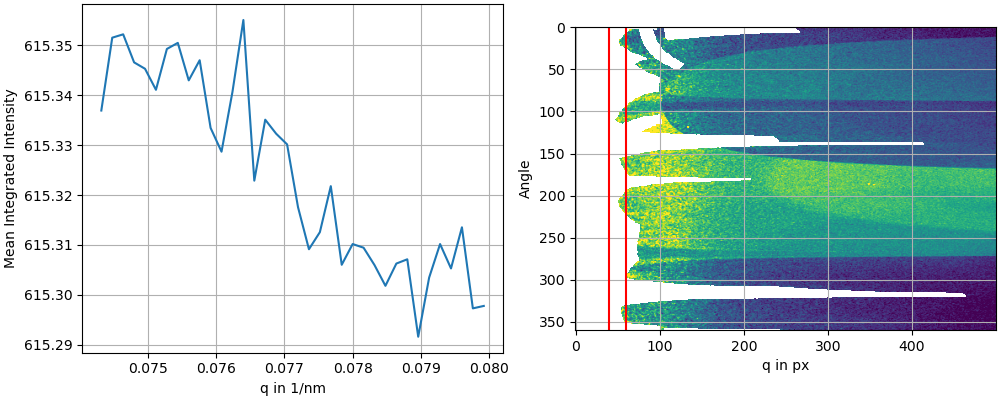

In [163]:
aic = interactive.AzimuthalIntegrationCenter(
    image,
    ai,
    c0=center[0],
    c1=center[1],
    im_data_range=[1, 99],
    radial_range=(0, 0.08),
    qlines=[40, 60],
    mask=mask,
)

In [164]:
# Get center positions
center = [aic.c0, aic.c1]
data = data.assign_attrs({"center": center})
print(f"Center:", center)

Center: [1145.0, 1045.0]


# Azimuthal integration for all images

In [165]:
# Update center of azimuthal integrator
ai = AzimuthalIntegrator(
    dist=experimental_setup["ccd_dist"],
    detector=detector,
    wavelength=experimental_setup["lambda"],
    poni1=center[0]
    * experimental_setup["px_size"]
    * experimental_setup["binning"],  # y (vertical)
    poni2=center[1]
    * experimental_setup["px_size"]
    * experimental_setup["binning"],  # x (horizontal)
)

In [166]:
# Do 2d Azimuthal integration of all images and append them to list
list_i2d = []
for i, im in enumerate(tqdm(data["images"].values)):
    # Adapt azimuthal integrator if scan is an energy scan
    if key == "energy":
        ai.wavelength = cci.photon_energy_wavelength(
            data["energy"][i].values, input_unit="eV"
        )
    elif key == "br1_master":
        ai.wavelength = cci.photon_energy_wavelength(
            data[key][i].values, input_unit="eV"
        )

    # Calc ai
    i2d, q, chi = ai.integrate2d(im, 500, 90, dummy=np.nan, mask=mask)
    list_i2d.append(i2d)

data["q"] = q
data["chi"] = chi
data["i2d"] = xr.DataArray(list_i2d, dims=["index", "chi", "q"])

  0%|          | 0/17 [00:00<?, ?it/s]

## Select relevant chi-range

Text(0.5, 0, 'q')

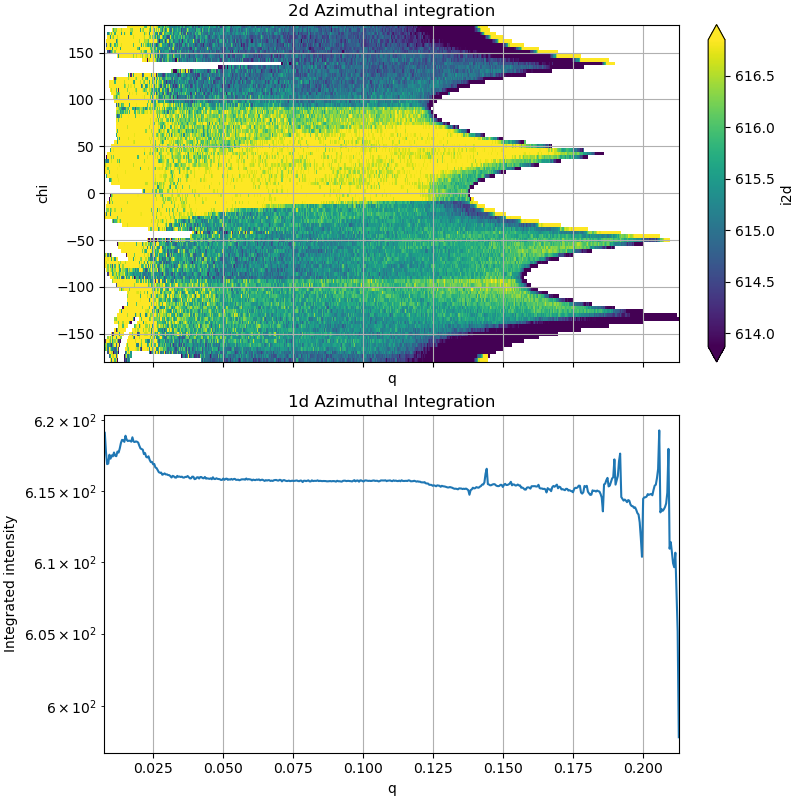

In [167]:
# Plot 2d and 1d azimuthal integration to estimate the relevant chi and q range
# which image to show?
idx = 7

# Select chi-range
# Which chi-mode? ("all","other")
chi_mode = "all"

# Select chi-range
if chi_mode == "all":
    sel_chi = (data.chi <= 180) * (data.chi >= -180)
    data["i1d"] = data.i2d.where(sel_chi, drop=True).mean("chi")
elif chi_mode == "other":
    sel_chi = (data.chi <= 150) * (data.chi >= 40)
    data["i1d"] = data.i2d.where(sel_chi, drop=True).mean("chi")

# Plot
fig, ax = plt.subplots(
    2,
    1,
    figsize=(8, 8),
    sharex=True,
)
mi, ma = np.nanpercentile(I_t, [0.1, 90])
data["i2d"][idx].plot.imshow(ax=ax[0], vmin=mi, vmax=ma)
ax[0].set_title(f"2d Azimuthal integration")
ax[0].grid()

# Plot 1d azimuthal integration to estimate the relevant q-range
ax[1].plot(data.q, data.i1d[idx])
ax[1].set_yscale("log")
ax[1].set_title("1d Azimuthal Integration")
ax[1].grid()
ax[1].set_ylabel("Integrated intensity")
ax[1].set_xlabel("q")

## Select relevant q-range

In [168]:
# Select relevant q-range for averaging
q0, q1 = 0.008, 0.05
binning = False
bins = []

# Get SAXS from q-range
sel = (data.q > q0) * (data.q < q1)
data["saxs"] = data.i1d.where(sel, drop=True).mean("q")

# Averaging of same scan axis values or binning
if binning is True:
    # Execute binning
    data_bin = data.groupby_bins(key, bins).mean()

    # Rename binned values, drop intervals as those cannot be save in h5
    bin_scan_axis = scan_axis + "_bins"
    data_bin = data_bin.swap_dims({bin_scan_axis: key})
    data_bin = data_bin.drop(bin_scan_axis)
else:
    _, count = np.unique(data[key].values, return_counts=True)
    if np.any(count > 1):
        data_bin = data.groupby(key).mean()
    else:
        data_bin = data.swap_dims({"index": key})

# Plotting

Saving:/asap3/petra3/gpfs/p04/2023/data/11019143/processed/SAXS_ImId_1378_cklose.png


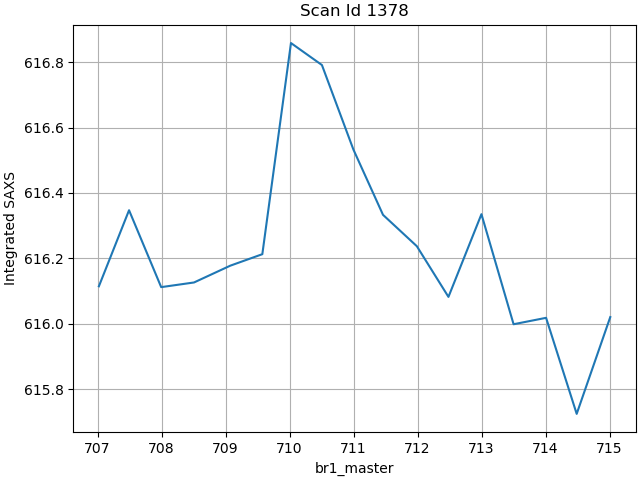

In [169]:
# Plot Intensity of SAXS Pattern
fig, ax = plt.subplots()
ax.plot(data_bin[key].values, data_bin["saxs"].values)
ax.grid()
ax.set_xlabel(key)
ax.set_ylabel("Integrated SAXS")

## Title and fname
if len(im_ids) > 1:
    ax.set_title("Scan Id %s-%s" % (im_ids[0], im_ids[-1]))
    fname = "SAXS_ImId_%04d-%04d_%s.png" % (im_ids[0], im_ids[-1], USER)
else:
    ax.set_title("Scan Id %d" % (im_ids[0]))
    fname = "SAXS_ImId_%04d_%s.png" % (im_ids[0], USER)

fname = join(folder_general, fname)
print("Saving:%s" % fname)
plt.savefig(fname)

# Export scan as gif

## Select roi of images for plotting

How to use:
1. Zoom into the image and adjust your FOV until you are satisfied.
2. Save the axes coordinates.

interactive(children=(FloatRangeSlider(value=(603.9000244140625, 658.7999877929688), description='contrast', l…

interactive(children=(IntSlider(value=0, description='nr', max=16), Output()), _dom_classes=('widget-interact'…

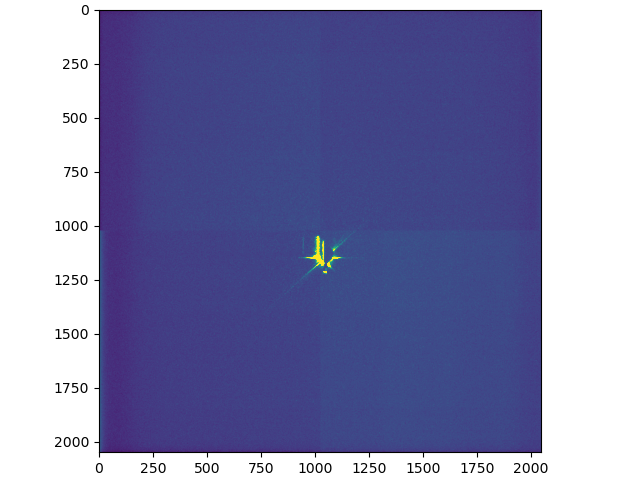

In [170]:
fig, ax = cimshow(data_bin["images"].values)

In [171]:
# Takes start and end of x and y axis
roi = interactive.axis_to_roi(ax)
print(f"Image registration roi:", roi)

Image registration roi: (slice(921, 1381, None), slice(807, 1297, None))


## Plotting

In [172]:
# Setup gif
folder_gif = sup.create_folder(join(folder_general, "ImId_%05d" % im_id))
variable_images_1d = []

# Find global max and min all images
allmin, allmax = np.nanpercentile(data_bin["i2d"].values, [1, 99.5])
allImin = data_bin.i1d.where(sel, drop=True).min()
allImax = data_bin.i1d.where(sel, drop=True).max()

# Loop over images
for i in tqdm(range(len(data_bin[key].values))):
    # Plot for averaged image
    fig = plt.figure(figsize=(6, 10))
    gs1 = gridspec.GridSpec(
        3,
        1,
        figure=fig,
        left=0.2,
        bottom=0.05,
        right=0.975,
        top=1.1,
        wspace=0,
        hspace=0,
        height_ratios=[3, 1, 1.5],
    )

    # Plot image roi
    ax0 = fig.add_subplot(gs1[0])
    m = ax0.imshow(data_bin["images"][i].values[roi], vmin=allmin, vmax=allmax)
    plt.colorbar(m, ax=ax0, pad=0.045, location="bottom")

    # Plot 1d azimuthal integration
    ax1 = fig.add_subplot(gs1[1])
    ax1.plot(data_bin.q, data_bin.i1d[i] + 1)
    ax1.set_xlabel("q")
    ax1.set_ylabel("Mean Intensity")
    ax1.set_xlim([q0, q1])
    ax1.set_ylim([allImin + 1, allImax + 1])
    ax1.set_yscale("log")
    ax1.grid()

    # Plot SAXS Intensity
    ax2 = fig.add_subplot(gs1[2])
    ax2.plot(data_bin[key].values, data_bin["saxs"].values)
    ax2.scatter(data_bin[key].values[i], data_bin["saxs"].values[i], 20, color="r")
    ax2.set_xlabel(key)
    ax2.set_ylabel("Mean intensity")
    ax2.grid()

    # Title and fname
    ax0.set_title(
        f"%04d - %04d %s = %s"
        % (im_ids[0], im_ids[-1], key, np.round(data_bin[key].values[i], 3))
    )
    fname = "SAXS_ImId_%04d_%04d_%03d_%s.png" % (im_ids[0], im_ids[-1], i, USER)

    # Save
    fname = path.join(folder_gif, fname)
    variable_images_1d.append(fname)
    plt.savefig(fname)
    plt.close()

# Create gif for 1d AI
if len(im_ids) > 1:
    fname = f"SAXS_ImId_%04d_%04d_%s.gif" % (im_ids[0], im_ids[-1], USER)
else:
    fname = f"SAXS_ImId_%04d_%s.gif" % (im_ids[0], USER)

var = [imageio.imread(file) for file in variable_images_1d]
gif_path = path.join(folder_general, fname)
print("Saving gif:%s" % gif_path)
imageio.mimsave(gif_path, var, fps=2)
print("Done!")

  0%|          | 0/17 [00:00<?, ?it/s]

Saving gif:/asap3/petra3/gpfs/p04/2023/data/11019143/processed/SAXS_ImId_1378_cklose.gif
Done!


In [174]:
# Drop images
data_bin_save = data_bin.drop_vars(["images"])

# Save log
folder = join(folder_general, "Logs")
sup.create_folder(folder)
fname = join(folder, "SAXS_Log_ImId_%04d_%s.nc" % (im_id, USER))

print(f"Saving:", fname)
data_bin_save.to_netcdf(fname)

Saving: /asap3/petra3/gpfs/p04/2023/data/11019143/processed/Logs/SAXS_Log_ImId_1378_cklose.nc
